In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision
from engine import train_one_epoch, evaluate

In [2]:
#загружаем базу
imgDir = os.path.join(os.getcwd(), "urbanhack-train", "images")
annFile = os.path.join(os.getcwd(), "urbanhack-train", "annotations", "instances_default.json") 
coco_obj = COCO(annFile)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [3]:
#информация  о самом датасете отсутствует, есть только фото и их аннотации, с ними и будем работать
coco_obj.info()

contributor: 
date_created: 
description: 
url: 
version: 
year: 


## 0. Создаем датафрейм из файла COCO (возможно, нам это пригодится)

In [4]:
#загружаем аннотации
df_anns = pd.DataFrame(coco_obj.anns).T
df_anns.set_index("id", inplace=True)
#из attributes уникальные значения есть только в 'rotation'
df_anns["rotation"] = df_anns["attributes"].apply(lambda x: list(x.values())[1])
#удаляем ПУСТЫЕ колонки
df_anns.drop(columns=["segmentation", "iscrowd", "attributes"], inplace=True)
#df_anns.info()
df_anns.head()

,image_id,category_id,area,bbox,rotation
id,,,,,
1,1,2,12677.0917,"[98.87, 141.25, 110.63, 114.59]",0.0
2,1,2,16279.1769,"[723.17, 184.07, 130.83, 124.43]",0.0
3,1,2,13944.2534,"[475.7, 48.84, 116.62, 119.57]",0.0
4,1,2,13847.1183,"[593.81, 62.38, 118.89, 116.47]",0.0
5,1,2,10862.957,"[0.0, 259.95, 81.34, 133.55]",0.0


In [5]:
#загружаем информацию по изображениям
df_images = pd.DataFrame(coco_obj.imgs).T
df_images.rename({"id" : "image_id"}, axis=1, inplace=True)
df_images.set_index("image_id", inplace=True)
#удаляем ПУСТЫЕ колонки
df_images.drop(columns=["license", "flickr_url", "coco_url", "date_captured"], inplace=True)
#df_images.info()
df_images.head()

,width,height,file_name
image_id,,,
1,854,572,0000019949building.jpg
2,881,720,0000019869building.jpg
3,847,544,0000019458building.jpg
4,303,600,0000019455building.jpg
5,869,676,0000019431building.jpg


In [6]:
df_cats = pd.DataFrame(coco_obj.cats).T
df_cats.rename({"id" : "category_id"}, axis=1, inplace=True)
df_cats.set_index("category_id", inplace=True)
df_cats.drop(columns="supercategory",inplace=True)
df_cats.head()

,name
category_id,
1,window
2,empty
3,filled


In [7]:
#объединяем все данные в одну таблицу
df = df_anns
df = df.merge(right=df_images, left_on="image_id", right_index=True)
df = df.merge(right=df_cats, left_on="category_id", right_index=True)
#отказался от дропа, так как эти колонки содержат id каждого bbox, может пригодится позже
#df.drop(columns=["image_id", "category_id"], inplace=True)
df.rename({"name" : "category"}, axis=1, inplace=True)
df.rename({"file_name" : "filename"}, axis=1, inplace=True)
#df.info()
df.head()

,image_id,category_id,area,bbox,rotation,width,height,filename,category
id,,,,,,,,,
1,1,2,12677.0917,"[98.87, 141.25, 110.63, 114.59]",0.0,854,572,0000019949building.jpg,empty
2,1,2,16279.1769,"[723.17, 184.07, 130.83, 124.43]",0.0,854,572,0000019949building.jpg,empty
3,1,2,13944.2534,"[475.7, 48.84, 116.62, 119.57]",0.0,854,572,0000019949building.jpg,empty
4,1,2,13847.1183,"[593.81, 62.38, 118.89, 116.47]",0.0,854,572,0000019949building.jpg,empty
5,1,2,10862.957,"[0.0, 259.95, 81.34, 133.55]",0.0,854,572,0000019949building.jpg,empty


In [8]:
#нужно с этим разобраться, см. вывод
df[(df["rotation"] != 0)]["filename"].value_counts()

filename
0000035095building.jpg    4
0000035089building.jpg    2
0000035087building.jpg    2
0000033910building.jpg    1
0000033907building.jpg    1
0000018897building.jpg    1
Name: count, dtype: int64

**Вывод**:

Прочитали данные из базы данных COCO, так как они хранились в разных таблицах, то мы их объединили. Предаварительно, из данных были удалены столбцы, которые не несли смысловой нагрузки.

**Описание данных**:

`area` - площадь bbox (bounding box или bbox- это прямоугольник, размеченная область фотографии, которой мы и присваиваем класс, на одной фотографии можеть несколько bbox) \
`bbox` - координаты прямоугольника bounding box (x, y, width, height), координаты отсчитываются с левого верхнего угла \
`rotation` - вероятно, это поворот bbox (не здания, а самого bbox на фотографии), в датасете у нас всего лишь 11 таких повернутых(?) bbox (они есть в 6-ти фотографиях) \
`width` - ширина самой фотографии (а не bbox!)\
`height` - высота самой фотографии (а не bbox!)\
`filename` - имя файла фотографии из папки *images*\
`category` - класс объекта, то есть класс bbox, он может быть `empty` (пустой), `window` (окно) или `filled` (кладка?)

Что было удалено:\
`supercategory` - суперкатегория (у нас ее/их нет), например категории могут быть - олени, лоси, коровы, а суперкатегория для них - парнокопытные, но у нас такого деления нет\
`license`, `flickr_url`, `coco_url`, `date_captured` - пустые признаки у каждого bbox\
`segmentation` - пусто (вообще, нужен для задачи сегментации)\
`iscrowd` - у всех объектов установлена в ноль, вероятно, связана с `segmentation`\
`attributes` - внутри этого признака были подпризнаки `occluded`: False (у всех bbox одинаковый и поэтому был удален), `rotation` - оставлен


P. S. Описание данных можно посмотреть здесь https://cocodataset.org/#format-data (раздел **1. Object Detection**), однако там нет `rotation`.

## 1. Непосредтственная работа с COCO API

In [9]:
#список id всех изображений
images_ids = coco_obj.getImgIds()
print(f"{images_ids=}")
#загружаем все изображаения по их id
images_dict = coco_obj.loadImgs(images_ids)
print("Формат данных изображений - список словарей:")
print(f"{json.dumps(images_dict[:2], indent=4)}")

images_ids=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [10]:
def draw_anns(coco, image_dir, img_dict_data, verbose=False):
    #загружаем данные
    img_filename = img_dict_data["file_name"]
    im = cv2.imread(f"{image_dir}/{img_filename}")
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #рисуем изображение
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(20,30)
    for axes in ax:
        axes.axis("off") 
    print(f"Файл: {img_filename}")   
    #само изображение
    ax[0].imshow(im)
    ax[0].set_title(f"Оригинал: {img_filename}")
    #изображение с аннотациями (bbox)
    ax[1].imshow(im)
    ax[1].set_title(f"C аннотациями: {img_filename}")
    #похоже у COCO нельзя вывести изображение на конкретный Axes
    plt.sca(ax[1])
    #получаем список id всех аннотация для конкретного id изображения
    annIds = coco.getAnnIds(imgIds=img_dict_data["id"])
    #загружаем сами аннотации, используя список id для каждого изображения
    anns = coco.loadAnns(annIds)
    if verbose:
        print(f"id аннотаций изображения {img_filename}: {annIds}")
        print(f"Аннотации:{json.dumps(anns, indent=4)}")
    #метод COCO API для визуализации изображения и аннотаций
    coco.showAnns(anns, draw_bbox=True)
    plt.show()

def draw_anns_for_filename(imgDir, images, filename):
    for img in images:
        if filename.lower() in img["file_name"].lower():
            draw_anns(imgDir, img)

Файл: 0000005324building.jpg


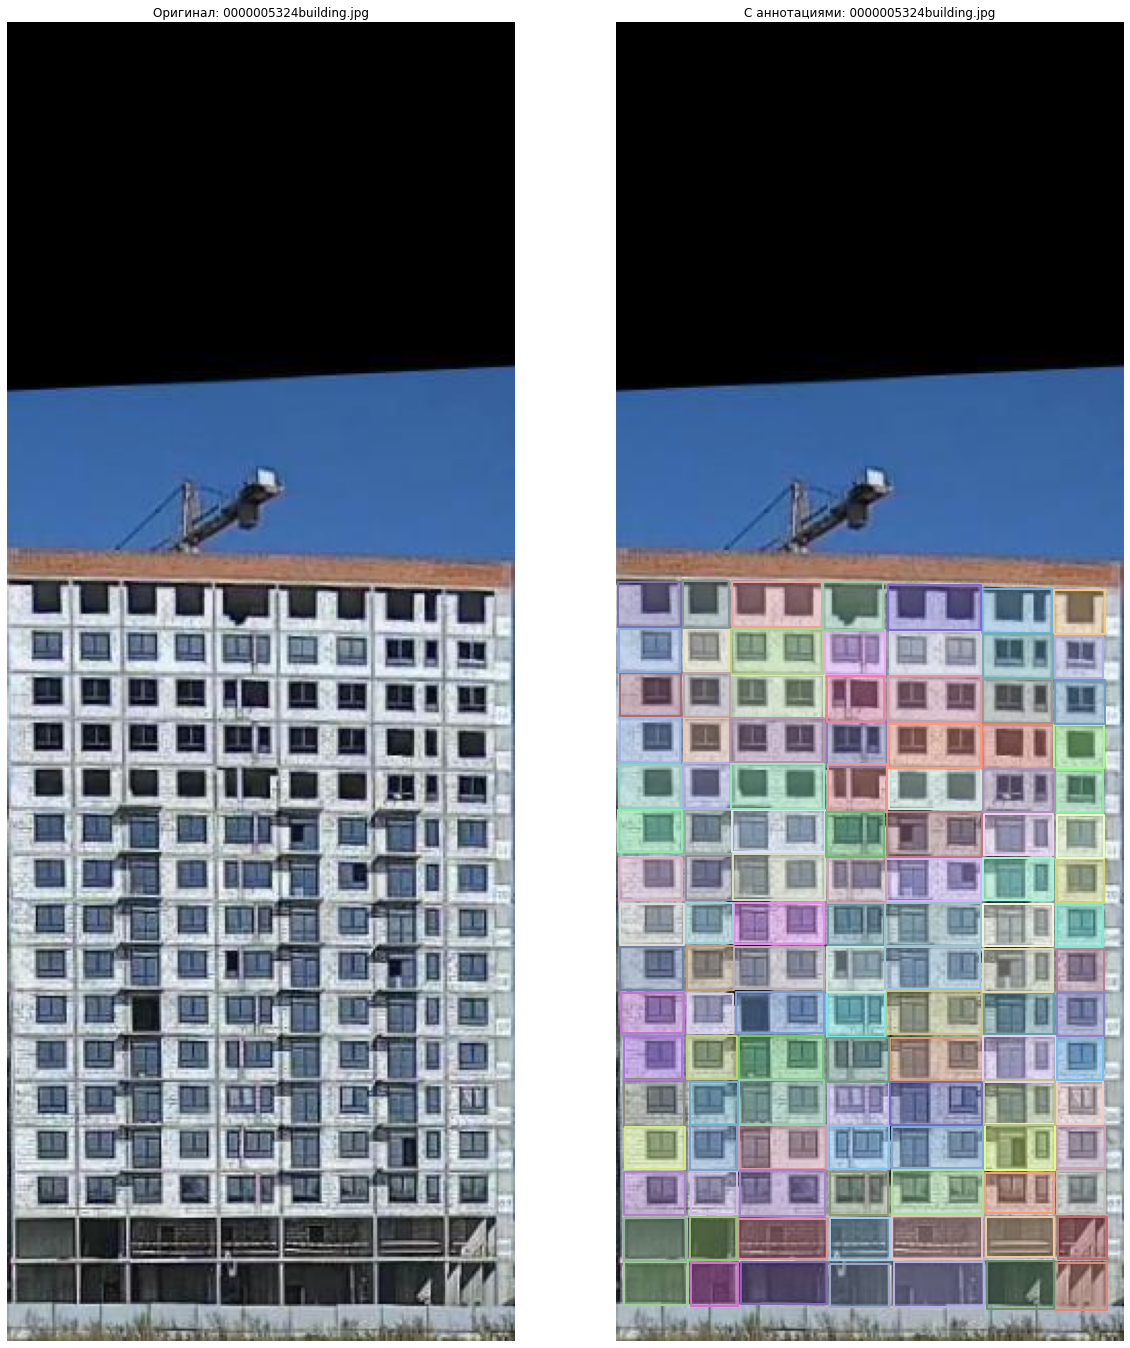

Файл: 0000014039building.jpg


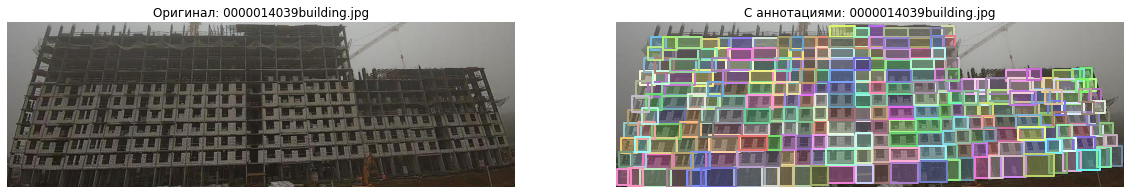

In [11]:
for i in range(2):
    draw_anns(coco=coco_obj, image_dir=imgDir, img_dict_data=np.random.choice(images_dict))
    

## 2. Подготовка модели

In [12]:
import torchvision.transforms as transforms
import torch
from PIL import Image

In [13]:
class BuildingsDataset(torch.utils.data.Dataset):
    def __init__(self, root, coco, transform=None):
        self.root = root
        self.transforms = transform
        self.coco = coco
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = self.coco.loadAnns(ann_ids)
        
        # open the input image
        path = self.coco.loadImgs(img_id)[0]["file_name"]
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([ann["category_id"] for ann in coco_annotation], dtype=torch.int64)

        # Annotation is in dictionary format
        new_annotation = {}
        new_annotation["boxes"] = boxes
        new_annotation["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)

        return img, new_annotation

    def __len__(self):
        return len(self.ids)
    
#the inputs for a PyTorch model must be in tensor format, so we use this to transform data
def get_transform():
    custom_transforms = []
    #PIL Image to Tensor transformation
    custom_transforms.append(transforms.ToTensor())
    return transforms.Compose(custom_transforms)

In [14]:
data = BuildingsDataset(root = imgDir,
                        coco = coco_obj,
                        transform = get_transform())
print("Количество картинок: ", len(data))

Количество картинок:  252


In [15]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# select device (whether GPU or CPU)
if torch.cuda.is_available():
    #gpu
    workers = 0
    device = torch.device("cuda") 
else:
    #cpu
    workers = 4
    device = torch.device("cpu")
    
# own DataLoader
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=workers,
                                          collate_fn=collate_fn)
#for testing purposes to check if dataloader works
# DataLoader is iterable over Dataset
images = []
annotations = []
#может возникнуть CUDA assertion error, в этом случае помогает перезапуск ядра Jupyter Notebook.
#причина ошибки мне неизвестна
for image, annotation in data_loader:
    images.append(image[0].to(device))
    print(annotation)
    annotations.append({k: v.to(device) for k, v in annotation[0].items()})
    print(annotations)
    break

({'boxes': tensor([[216.5800, 839.6500, 274.8000, 867.8600],
        [102.8000, 715.5600, 166.7000, 742.7100],
        [ 74.0900, 933.9700, 104.6900, 967.8800],
        [168.3000, 840.7500, 209.4600, 866.9800],
        [167.3000, 656.0500, 205.7300, 683.3900],
        [281.9300, 836.4800, 322.1200, 865.1500],
        [ 67.2000, 529.3800,  97.9500, 555.8500],
        [281.8600, 777.8200, 319.8800, 805.7200],
        [213.5000, 746.4300, 275.0000, 774.6100],
        [329.1200, 928.2100, 358.3500, 955.9100],
        [276.0000, 654.1000, 319.1400, 680.8900],
        [107.8500, 902.1900, 166.6000, 930.0100],
        [170.9400, 868.7800, 209.9000, 895.7800],
        [213.5600, 776.5700, 274.7000, 803.4700],
        [ 74.1600, 809.7100, 103.2900, 837.3100],
        [215.3200, 869.7900, 274.3000, 896.6300],
        [275.9000, 713.6500, 319.9100, 741.2400],
        [ 23.1000, 592.5400,  64.0900, 619.4000],
        [104.4000, 747.5800, 165.5000, 775.6600],
        [209.2100, 530.1600, 269.5000, 

## 3. Обучение модели

In [16]:
def get_object_detection_model(num_classes):
    # предобученная модель
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 
    return model

In [17]:
# подготовка
model = get_object_detection_model(4)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [18]:
# обучение
for epoch in range(1):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    #evaluate(model, test_data_loader, device=device)

Epoch: [0]  [  0/252]  eta: 0:08:04  lr: 0.000025  loss: 8.1325 (8.1325)  loss_classifier: 1.3496 (1.3496)  loss_box_reg: 0.2115 (0.2115)  loss_objectness: 6.3621 (6.3621)  loss_rpn_box_reg: 0.2093 (0.2093)  time: 1.9222  data: 0.0070  max mem: 3855
Epoch: [0]  [ 10/252]  eta: 0:02:04  lr: 0.000224  loss: 3.9296 (4.5254)  loss_classifier: 1.2954 (1.2387)  loss_box_reg: 0.3851 (0.4300)  loss_objectness: 1.7777 (2.5751)  loss_rpn_box_reg: 0.2300 (0.2815)  time: 0.5154  data: 0.0310  max mem: 4547
Epoch: [0]  [ 20/252]  eta: 0:01:41  lr: 0.000423  loss: 2.1394 (3.2972)  loss_classifier: 0.9465 (1.0291)  loss_box_reg: 0.4430 (0.4883)  loss_objectness: 0.4964 (1.5480)  loss_rpn_box_reg: 0.1681 (0.2318)  time: 0.3653  data: 0.0357  max mem: 4547
Epoch: [0]  [ 30/252]  eta: 0:01:26  lr: 0.000622  loss: 1.8864 (2.8170)  loss_classifier: 0.7815 (0.9418)  loss_box_reg: 0.5662 (0.5194)  loss_objectness: 0.3517 (1.1554)  loss_rpn_box_reg: 0.1470 (0.2003)  time: 0.3226  data: 0.0267  max mem: 4547


In [20]:
test_index = np.random.randint(0, len(data))
print(test_index)
img, target = data[test_index]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]
print(prediction)

168
{'boxes': tensor([[2.3208e+03, 8.9723e+02, 2.9912e+03, 1.2656e+03],
        [1.7472e+03, 9.0343e+02, 2.3455e+03, 1.2599e+03],
        [1.8272e+03, 1.7658e+03, 2.1288e+03, 1.8997e+03],
        [3.0220e+01, 6.0628e+02, 2.8964e+02, 8.6006e+02],
        [4.9522e+02, 5.9989e+02, 9.8153e+02, 8.7561e+02],
        [1.6922e+03, 1.2663e+03, 2.4231e+03, 1.8976e+03],
        [2.3092e+03, 5.8098e+02, 2.9453e+03, 8.7968e+02],
        [6.3543e+02, 3.2916e+02, 1.0450e+03, 5.8026e+02],
        [2.8729e+03, 5.8835e+02, 3.4063e+03, 8.9189e+02],
        [1.8616e+03, 1.9342e+03, 2.1400e+03, 2.1013e+03],
        [2.2880e+03, 3.0842e+02, 2.8908e+03, 5.7483e+02],
        [1.6172e+02, 6.0387e+02, 6.3405e+02, 8.5389e+02],
        [1.7522e+03, 3.1365e+02, 2.3436e+03, 5.8180e+02],
        [2.9357e+03, 8.9755e+02, 3.5035e+03, 1.2781e+03],
        [6.9170e+01, 1.2410e+03, 7.3421e+02, 1.8222e+03],
        [3.6970e+02, 8.8790e+02, 8.6128e+02, 1.2121e+03],
        [1.4805e+03, 1.3478e+03, 1.6953e+03, 1.6784e+03],
